**Importing libraries**

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras

**Reading data**

In [2]:
tt1 = pd.read_csv('AzureReadings_at_a_timestamp1.csv')

In [3]:
tt1.head()

,timestamp,norm_min_cpu,norm_max_cpu,norm_avg
0,1/1/2017 0:00,0.2283,0.2346,0.2314
1,1/1/2017 0:05,0.2023,0.2282,0.2152
2,1/1/2017 0:10,0.2120,0.2286,0.2203
3,1/1/2017 0:15,0.1809,0.2137,0.1973
4,1/1/2017 0:20,0.1807,0.2114,0.1960


In [4]:
tt1['timestamp'] =  pd.to_datetime(tt1['timestamp'])

In [5]:
tt1 = tt1.set_index('timestamp')

In [6]:
tt1.head()

,norm_min_cpu,norm_max_cpu,norm_avg
timestamp,,,
2017-01-01 00:00:00,0.2283,0.2346,0.2314
2017-01-01 00:05:00,0.2023,0.2282,0.2152
2017-01-01 00:10:00,0.2120,0.2286,0.2203
2017-01-01 00:15:00,0.1809,0.2137,0.1973
2017-01-01 00:20:00,0.1807,0.2114,0.1960


In [7]:
tt = tt1

In [8]:
dataset = tt.values
dataset = dataset.astype('float32')

In [9]:
len(dataset)

8640

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

6912 1728


In [12]:
def create_training_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :3]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 5
trainX, trainY = create_training_dataset(train, look_back=look_back)
testX, testY = create_training_dataset(test, look_back=look_back)

**Building Model**

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.GRU(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(keras.layers.Dense(3))

In [15]:
adamOpt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adamOpt, metrics=['mae'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               51072     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 51,459
Trainable params: 51,459
Non-trainable params: 0
_________________________________________________________________


**Training Model**

In [17]:
history = model.fit(trainX, trainY, validation_split=0.25,epochs=20, batch_size=64, verbose=2)

Epoch 1/20
81/81 - 2s - loss: 0.0051 - mae: 0.0444 - val_loss: 6.2251e-04 - val_mae: 0.0198
Epoch 2/20
81/81 - 1s - loss: 7.6579e-04 - mae: 0.0184 - val_loss: 5.1414e-04 - val_mae: 0.0178
Epoch 3/20
81/81 - 1s - loss: 6.8615e-04 - mae: 0.0172 - val_loss: 4.9097e-04 - val_mae: 0.0174
Epoch 4/20
81/81 - 1s - loss: 6.4999e-04 - mae: 0.0166 - val_loss: 4.7099e-04 - val_mae: 0.0170
Epoch 5/20
81/81 - 1s - loss: 6.2046e-04 - mae: 0.0163 - val_loss: 4.6031e-04 - val_mae: 0.0169
Epoch 6/20
81/81 - 1s - loss: 5.8769e-04 - mae: 0.0159 - val_loss: 4.5440e-04 - val_mae: 0.0165
Epoch 7/20
81/81 - 1s - loss: 5.6139e-04 - mae: 0.0155 - val_loss: 4.4122e-04 - val_mae: 0.0163
Epoch 8/20
81/81 - 1s - loss: 5.4673e-04 - mae: 0.0154 - val_loss: 4.5674e-04 - val_mae: 0.0168
Epoch 9/20
81/81 - 1s - loss: 5.2691e-04 - mae: 0.0151 - val_loss: 4.3310e-04 - val_mae: 0.0157
Epoch 10/20
81/81 - 1s - loss: 5.1591e-04 - mae: 0.0150 - val_loss: 4.3170e-04 - val_mae: 0.0159
Epoch 11/20
81/81 - 1s - loss: 5.0914e-04 -

**Predicting**

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [19]:
trainY = scaler.inverse_transform(trainY)
trainPredict = scaler.inverse_transform(trainPredict)
testY = scaler.inverse_transform(testY)
testPredict = scaler.inverse_transform(testPredict)

**Evaluating Model**

1. Evaluation metrics: RMSE(Root Mean Square Error)

In [26]:
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %f RMSE' % (testScore))

Train Score: 0.021127 RMSE
Test Score: 0.022618 RMSE


2. Evaluation metrics: MAE(Mean Absolute Error)

In [21]:
from sklearn.metrics import mean_absolute_error
trainScore = (mean_absolute_error(trainY[:], trainPredict[:]))
print('Train Score: %f MAE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY[:], testPredict[:]))
print('Test Score: %f MAE' % (testScore))

Train Score: 0.014221 MAE
Test Score: 0.124529 MAE


3. Evaluation metric: MAPE(Mean absolute percentage error)

**Percentage errors**

The percentage error is given by  
p
t
=
100
e
t
/
y
t
 . 

Percentage errors have the advantage of being unit-free, and 
so are frequently used to compare forecast performances between data sets. 

The most commonly used measure is:
Mean absolute percentage error: MAPE
=
mean
(
|
p
t
|
)


In [22]:
trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))
print('Train Score: %f MAPE' % (trainScore2))
testScore2 = np.mean(np.abs(testPredict - testY)/np.abs(testY))
print('Test Score: %f MAPE' % (testScore2))

Train Score: inf MAPE
Test Score: 0.058535 MAPE


C:\Users\91956\AppData\Local\Temp/ipykernel_13408/1226192089.py:1: RuntimeWarning: divide by zero encountered in true_divide
  trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))


4. Evaluation metric: Correaltion

In [23]:
trainScore3 = np.corrcoef(trainPredict, trainY)[0,1]
print('Train Score: %f COR' % (trainScore3))
testScore2 = np.corrcoef(testPredict, testY)[0,1]
print('Test Score: %f COR' % (testScore2))

C:\Users\91956\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\91956\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Train Score: 0.998715 COR
Test Score: 0.988406 COR


**Plotting Graphs**

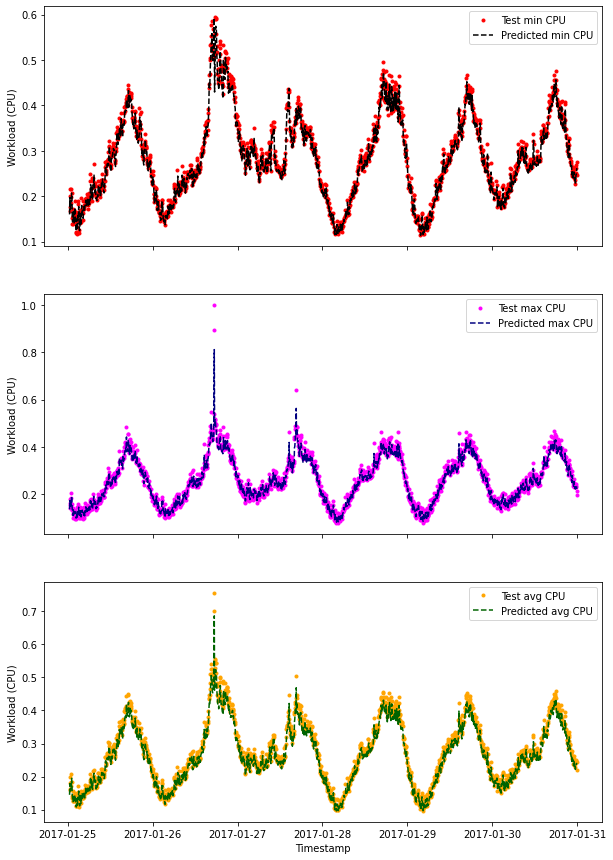

In [25]:
index=tt.index
TestY= pd.DataFrame(testY,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(testPredict,columns=['min_cpu','max_cpu','avg_cpu'])

x=index[-1722:]
fig, axs = plt.subplots(3,figsize=(10,15))

axs[0].plot(x,TestY.min_cpu,'.',label='Test min CPU',color='red')
axs[0].plot(x,PredY.min_cpu,'--',label='Predicted min CPU',color='black')
axs[0].legend()
axs[1].plot(x,TestY.max_cpu,'.',label='Test max CPU',color='magenta')
axs[1].plot(x,PredY.max_cpu,'--',label='Predicted max CPU',color='navy')
axs[1].legend()
axs[2].plot(x,TestY.avg_cpu,'.',label='Test avg CPU',color='orange')
axs[2].plot(x,PredY.avg_cpu,'--',label='Predicted avg CPU',color='darkgreen')
axs[2].legend()
for ax in axs.flat:
    ax.set(xlabel='Timestamp', ylabel='Workload (CPU)',autoscale_on=True)
for ax in axs:
    ax.label_outer()
#fig.suptitle('Prediction of Workload on Azure cloud at a particular timestamp',fontsize=20)
plt.savefig('LSTM output.png', dpi = 300)
plt.show()